```markdown
# Resumo do Trabalho

Este trabalho aborda a resolução do problema de agendamento de tarefas com restrições de precedência e capacidade de recursos. Utilizamos a biblioteca fornecida pelo professor chamada de `constraint` para modelar e resolver o problema, definindo variáveis, restrições de precedência, e restrições de capacidade de recursos.

## Estrutura do Código

1. **Definição de Classes**:
    - `Recurso`: Representa um recurso disponível.
    - `Tarefa`: Representa uma tarefa com duração e consumo de recursos.
    - `DadosDoProblema`: Contém todas as informações do problema, incluindo horizonte, data limite, recursos, tarefas e precedências.

2. **Funções de Processamento**:
    - `process_general_info`: Processa informações gerais do problema.
    - `process_precedence`: Processa relações de precedência entre tarefas.
    - `process_duration_resources`: Processa a duração e os recursos consumidos por cada tarefa.
    - `process_resource_availability`: Processa a disponibilidade de recursos.

3. **Função de Parsing**:
    - `file_parser`: Lê um arquivo de entrada e cria uma instância de `DadosDoProblema`.

4. **Resolução do Problema**:
    - `scheduler_resolver`: Resolve o problema de agendamento, considerando as restrições de precedência e capacidade de recursos.

5. **Visualização**:
    - Geração de um gráfico de Gantt para visualizar o cronograma das tarefas.

Esta e a estrutura do codigo desenvolvido
```

```markdown
 # teste
```

In [14]:
from dataclasses import dataclass
from typing import Dict, List, Any
from constraint import Problem
import re

import matplotlib.pyplot as plt

In [15]:
@dataclass
class Recurso:
    nome: str
    quantidade: int  # Disponibilidade total do recurso

@dataclass
class Tarefa:
    id: int
    duracao: int
    recursos: Dict[str, int]  # Nome do recurso e quantidade consumida

@dataclass
class DadosDoProblema:
    horizonte: int
    data_limite: int
    recursos: Dict[str, Recurso]  # Nome do recurso -> Recurso
    tarefas: Dict[int, Tarefa]  # ID da tarefa -> Tarefa
    precedencia: Dict[int, List[int]]  # ID da tarefa -> IDs dos sucessores

    def __str__(self):
        output = [
            "=== Dados do Problema ===",
            f"Horizonte: {self.horizonte}",
            f"Data Limite: {self.data_limite}",
            "Recursos Disponíveis:"
        ]
        for recurso in self.recursos.values():
            output.append(f"  {recurso.nome}: {recurso.quantidade}")

        output.append("Tarefas:")
        for tarefa in self.tarefas.values():
            recursos = ", ".join([f"{k}: {v}" for k, v in tarefa.recursos.items()])
            output.append(
                f"  Tarefa {tarefa.id}: Duração {tarefa.duracao}, Consumo de Recursos [{recursos}]"
            )

        output.append("Precedência:")
        for tarefa, sucessores in self.precedencia.items():
            output.append(f"  Tarefa {tarefa} -> Sucessores: {sucessores}")

        return "\n".join(output)

In [16]:
def process_general_info(line, data):
    if "horizon" in line:
        data['horizonte'] = int(re.findall(r"\d+", line)[0])
    elif "duedate" in line:
        duedate = re.findall(r"\d+", line)
        if duedate:
            data['data_limite'] = int(duedate[0])


In [17]:
def process_precedence(line, data):
    if line and not line.startswith("*"):
        partes = list(map(int, re.findall(r"\d+", line)))
        if len(partes) >= 3:
            job = partes[0]
            num_modes = partes[1]
            num_sucessores = partes[2]
            sucessores = partes[3:3+num_sucessores]
            data['precedencia'][job] = sucessores
        else:
            print(f"Erro ao processar linha de precedência: {line}")

In [18]:
def process_duration_resources(line, data, recursos_nomes):
    if line and not line.startswith("*"):
        partes = re.findall(r"\d+", line)
        if len(partes) >= 3:
            job = int(partes[0])
            duracao = int(partes[2])
            if duracao > 0:
                recursos = {nome: int(quant) for nome, quant in zip(recursos_nomes, partes[3:])}
                data['tarefas'][job] = Tarefa(id=job, duracao=duracao, recursos=recursos)
            else:
                # Ignora tarefas com duração 0
                print(f"Tarefa {job} com duração 0 ignorada.")

In [19]:
def process_resource_availability(line, data):
    if line and not line.startswith("*") and not line.lower().startswith("#resource") and not line.startswith("qty"):
        parts = line.split()
        if len(parts) == 2:
            try:
                nome = parts[0]
                quantidade = int(parts[1])
                data['recursos'][nome] = Recurso(nome=nome, quantidade=quantidade)
            except ValueError:
                print(f"Erro ao processar linha de recursos: {line}")

In [20]:
def file_parser(file_path) -> DadosDoProblema:
    data = {
        'horizonte': 0,
        'data_limite': 0,
        'recursos': {},
        'tarefas': {},
        'precedencia': {}
    }

    recursos_nomes = []

    with open(file_path, 'r') as file:
        current_section = None

        for line in file:
            line = line.strip()
            if line.startswith("#General Information"):
                current_section = 'general_info'
            elif line.startswith("#Precedence relations"):
                current_section = 'precedence'
            elif line.startswith("#Duration and resources"):
                current_section = 'duration_resources'
            elif line.startswith("#Resource availability"):
                current_section = 'resource_availability'
            elif current_section == 'general_info':
                process_general_info(line, data)
            elif current_section == 'precedence':
                process_precedence(line, data)
            elif current_section == 'duration_resources':
                if line.startswith("#jobnr."):
                    recursos_nomes = re.findall(r"R\d+", line)  # Identificar recursos
                else:
                    process_duration_resources(line, data, recursos_nomes)
            elif current_section == 'resource_availability':
                process_resource_availability(line, data)

    return DadosDoProblema(
        horizonte=data['horizonte'],
        data_limite=data['data_limite'],
        recursos=data['recursos'],
        tarefas=data['tarefas'],
        precedencia=data['precedencia']
    )

In [21]:
def scheduler_resolver(data: DadosDoProblema) -> Any:
    problem = Problem()

    # Filtra as tarefas com duração maior que 0
    tarefas_validas = {tarefa_id: tarefa for tarefa_id, tarefa in data.tarefas.items() if tarefa.duracao > 0}

    # Define o makespan desejado
    makespan_desejado = 11

    # Variáveis de decisão: tempo de início de cada tarefa válida
    for tarefa_id, tarefa in tarefas_validas.items():
        max_start_time = makespan_desejado - tarefa.duracao
        # Cada variável representa o tempo de início possível da tarefa
        problem.addVariable(str(tarefa_id), range(max_start_time + 1))

    problem.addConstraint(lambda start: start == 1, (str(1)))

    # Restrições de Precedência
    def create_precedence_constraint(job_duration):
        return lambda sp, ss: sp + job_duration <= ss

    for predecessor, successors in data.precedencia.items():
        if predecessor in tarefas_validas:
            for successor in successors:
                if successor in tarefas_validas:
                    problem.addConstraint(
                        create_precedence_constraint(tarefas_validas[predecessor].duracao),
                        (str(predecessor), str(successor))
                    )
                    # Garante que a tarefa 'successor' só comece após o término da tarefa 'predecessor'

    # Restrições que garantem que as tarefas terminem antes do makespan
    for tarefa_id, tarefa in tarefas_validas.items():
        def makespan_constraint(inicio, duracao=tarefa.duracao):
            return inicio + duracao <= makespan_desejado
        problem.addConstraint(
            makespan_constraint,
            [str(tarefa_id)]
        )

    # Restrições de Capacidade de Recursos
    def restricao_recursos(*valores_inicio):
        consumo = {recurso: [0] * makespan_desejado for recurso in data.recursos}

        for tarefa_id, inicio in zip(tarefas_validas.keys(), valores_inicio):
            tarefa = tarefas_validas[tarefa_id]
            for t in range(inicio, inicio + tarefa.duracao):
                if t >= makespan_desejado:
                    return False  # A tarefa não pode ultrapassar o makespan
                for recurso, quantidade in tarefa.recursos.items():
                    consumo[recurso][t] += quantidade
                    if consumo[recurso][t] > data.recursos[recurso].quantidade:
                        return False  # Excede a capacidade do recurso em algum tempo
        return True  # Restrições de recursos satisfeitas

    # Adiciona a restrição de recursos ao problema
    problem.addConstraint(restricao_recursos, [str(tarefa_id) for tarefa_id in tarefas_validas])

    # Resolver o problema
    solutions = problem.getSolutions()

    def evaluate_solution(solution):
        total_start_time = sum(int(solution[str(tarefa_id)]) for tarefa_id in tarefas_validas)
        total_finish_time = sum(
            int(solution[str(tarefa_id)]) + tarefas_validas[tarefa_id].duracao for tarefa_id in tarefas_validas)
        return (total_start_time, total_finish_time)

    solutions.sort(key=evaluate_solution)

    solution = solutions[0]

    if solution is None:
        return f"Nenhuma solução encontrada com makespan = {makespan_desejado}"

    # Formatando a solução
    resultado = []
    for tarefa_id, inicio in solution.items():
        if tarefa_id != 'makespan':
            tarefa = tarefas_validas[int(tarefa_id)]
            resultado.append({
                "Tarefa": tarefa_id,
                "Tempo de Início": inicio,
                "Tempo de Fim": inicio + tarefa.duracao,
                "Duração": tarefa.duracao
            })

    return sorted(resultado, key=lambda x: int(x["Tarefa"]))


Erro ao processar linha de precedência: #jobnr.    #modes  #successors   successors
Tarefa | Tempo de Início | Tempo de Fim | Duração
     1 |               1 |          3 |       2
     2 |               3 |          6 |       3
     3 |               3 |          7 |       4
     4 |              10 |         11 |       1
     5 |               3 |          5 |       2
     6 |               7 |         10 |       3
     7 |               6 |         10 |       4
     8 |              10 |         11 |       1


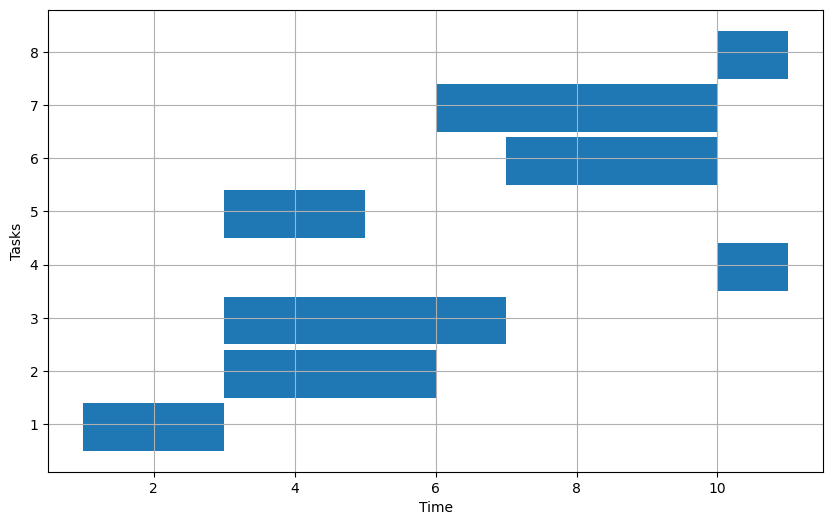

In [22]:
dados = file_parser("dataset_8.txt")
resultado = scheduler_resolver(dados)

if isinstance(resultado, str):
    print(resultado)  # Mensagem de erro, se houver
else:
    print("Tarefa | Tempo de Início | Tempo de Fim | Duração")
    for tarefa in resultado:
        print(f"{tarefa['Tarefa']:>6} | {tarefa['Tempo de Início']:>15} | {tarefa['Tempo de Fim']:>10} | {tarefa['Duração']:>7}")

    # Gantt chart visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    for tarefa in resultado:
        ax.broken_barh([(tarefa['Tempo de Início'], tarefa['Duração'])], (int(tarefa['Tarefa']) * 10, 9),
                       facecolors=('tab:blue'))

    ax.set_xlabel('Time')
    ax.set_ylabel('Tasks')
    ax.set_yticks([int(tarefa['Tarefa']) * 10 + 5 for tarefa in resultado])
    ax.set_yticklabels([tarefa['Tarefa'] for tarefa in resultado])
    ax.grid(True)

    plt.show()
